In [2]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
from tensorflow.keras.utils import normalize
from tqdm import tqdm

from Unet import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import load_model


In [1]:
#from numba import cuda
#device = cuda.get_current_device()
#device.reset()

In [3]:
# E-Optha dataset
#root = 'D:/Work/Retinopathy/eye dataset/Diabetic Retinopathy/segmentation/e_ophtha/e_ophtha_EX/e_optha_EX/'
#print(os.listdir(root))
#image_directory = os.path.join(root, 'agumented/EX_images/')
#mask_directory = os.path.join(root, 'agumented/EX_masks/')

['agumented', 'Annotation_EX', 'EX', 'e_ophta_EX.html', 'healthy', 'sorted', 'sorted train test']


In [21]:
# IDRiD dataset
root = 'D:/Work/Retinopathy/eye dataset/Diabetic Retinopathy/IDRiD/A.%20Segmentation/A. Segmentation/agumented/training/' 
image_directory = os.path.join(root, 'Images/')
mask_directory = os.path.join(root, 'gt/Hard exudates/')


In [22]:
print(os.listdir(image_directory)[0:5])
print(os.listdir(mask_directory)[0:5])

['Hflip_IDRiD_01.png', 'Hflip_IDRiD_02.png', 'Hflip_IDRiD_03.png', 'Hflip_IDRiD_04.png', 'Hflip_IDRiD_05.png']
['Hflip_IDRiD_01_EX.png', 'Hflip_IDRiD_02_EX.png', 'Hflip_IDRiD_03_EX.png', 'Hflip_IDRiD_04_EX.png', 'Hflip_IDRiD_05_EX.png']


In [23]:
print(len(os.listdir(image_directory)))
print(len(os.listdir(mask_directory)))

432
432


In [ ]:
# tried with gray scale images file :unet_exe_seg.h5 
# trying for green channel images for better segmentation

In [6]:
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8,8))


In [24]:
image_dataset = []  
mask_dataset = []  
SIZE = 256

In [25]:
images = os.listdir(image_directory)
for i, image_name in tqdm(enumerate(images)):    
    if (image_name.split('.')[1] == 'png' or 'TIF' or 'jpg'):
        image = cv.imread(image_directory+image_name)
        _,g,_ = cv.split(image)
        g_cl = clahe.apply(g)
        g_cl = Image.fromarray(g_cl)
        g_cl = g_cl.resize((SIZE, SIZE))
        image_dataset.append(np.array(g_cl))

432it [04:10,  1.72it/s]


In [26]:
masks = os.listdir(mask_directory)
for i, image_name in tqdm(enumerate(masks)):
    if (image_name.split('.')[1] == 'png' or 'TIF' or 'jpg'):
        image = cv.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

432it [00:23, 18.17it/s]


In [27]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


In [28]:
print("Used memory to store the float image dataset is: ", image_dataset.nbytes/(1024*1024), "MB")
print("Used memory to store the float mask dataset is: ", mask_dataset.nbytes/(1024*1024), "MB")


Used memory to store the float image dataset is:  216.0 MB
Used memory to store the float mask dataset is:  216.0 MB


In [29]:
print(image_dataset.shape)
print(mask_dataset.shape)

(432, 256, 256, 1)
(432, 256, 256, 1)


In [30]:
image_train, image_test, mask_train, mask_test = train_test_split(image_dataset,
                                                                  mask_dataset,
                                                                  test_size = 0.20,
                                                                  random_state = 10)

print(len(image_train))
print(len(image_test))

345
87


In [14]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 4640        dropout[0][0]                    
______________________________________________________________________________________________

In [15]:
batch_size = 1
callbacks = [
        EarlyStopping(patience=10, monitor='val_loss', mode = 'min'),
        TensorBoard(log_dir='logs')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model_checkpoint = ModelCheckpoint('exudates_unet_checkpoints_green.hdf5',
                                    monitor = 'val_accuracy',
                                    verbose = 1,
                                    save_best_only= True,
                                    mode= 'max')


history = model.fit(image_train,
                        mask_train,
                        batch_size= batch_size,
                        steps_per_epoch= np.ceil(len(image_train)//batch_size),
                        epochs = 10, 
                        validation_steps= np.ceil(len(image_test)//batch_size),     
                        validation_data = (image_test, mask_test),
                        callbacks=(reduce_lr,model_checkpoint)
                             )
print('Model Trained')


Epoch 1/10
1194/1194 [==============================] - 436s 280ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.0129 - val_accuracy: 0.9941

Epoch 00001: val_accuracy improved from -inf to 0.99414, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 2/10
1194/1194 [==============================] - 275s 230ms/step - loss: 0.0130 - accuracy: 0.9939 - val_loss: 0.0119 - val_accuracy: 0.9941

Epoch 00002: val_accuracy improved from 0.99414 to 0.99414, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 3/10
1194/1194 [==============================] - 274s 230ms/step - loss: 0.0114 - accuracy: 0.9939 - val_loss: 0.0134 - val_accuracy: 0.9941

Epoch 00003: val_accuracy did not improve from 0.99414
Epoch 4/10
1194/1194 [==============================] - 274s 229ms/step - loss: 0.0103 - accuracy: 0.9938 - val_loss: 0.0101 - val_accuracy: 0.9941

Epoch 00004: val_accuracy improved from 0.99414 to 0.99414, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 5/10
11

In [16]:
model.save('unet_exe_green_seg.h5')

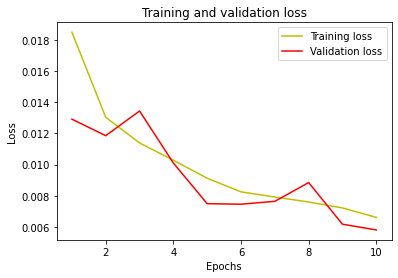

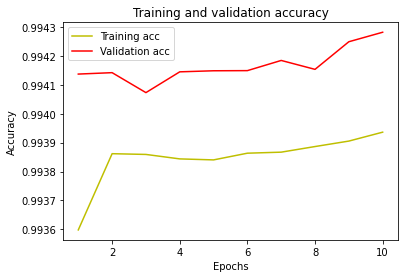

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


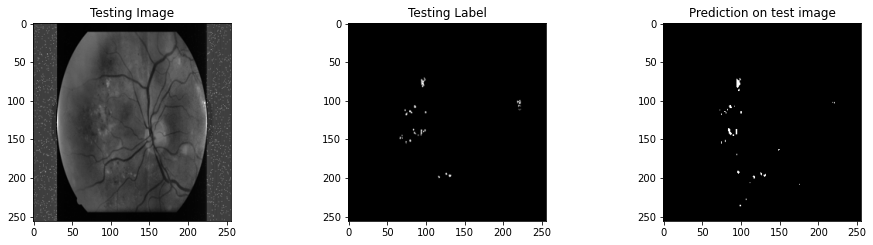

In [20]:
from keras.models import load_model
#model = load_model('unet_exe_seg.h5')
test_img_number = random.randint(0, len(image_test))
test_img = image_test[test_img_number]
ground_truth=mask_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

In [31]:
model = load_model('unet_exe_green_seg.h5')

batch_size = 1
callbacks = [
        EarlyStopping(patience=10, monitor='val_loss', mode = 'min'),
        TensorBoard(log_dir='logs')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model_checkpoint = ModelCheckpoint('exudates_unet_checkpoints_green.hdf5',
                                    monitor = 'val_accuracy',
                                    verbose = 1,
                                    save_best_only= True,
                                    mode= 'max')

print('Model Retraining.... \n')

history = model.fit(image_train,
                        mask_train,
                        batch_size= batch_size,
                        steps_per_epoch= np.ceil(len(image_train)//batch_size),
                        epochs = 10, 
                        validation_steps= np.ceil(len(image_test)//batch_size),     
                        validation_data = (image_test, mask_test),
                        callbacks=(reduce_lr,model_checkpoint)
                             )
print('\n Model Retrained')


Model Retraining.... 

Epoch 1/10
345/345 [==============================] - 89s 249ms/step - loss: 0.0279 - accuracy: 0.9795 - val_loss: 0.0265 - val_accuracy: 0.9771

Epoch 00001: val_accuracy improved from -inf to 0.97705, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 2/10
345/345 [==============================] - 79s 230ms/step - loss: 0.0227 - accuracy: 0.9798 - val_loss: 0.0243 - val_accuracy: 0.9772

Epoch 00002: val_accuracy improved from 0.97705 to 0.97717, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 3/10
345/345 [==============================] - 79s 229ms/step - loss: 0.0215 - accuracy: 0.9799 - val_loss: 0.0228 - val_accuracy: 0.9776

Epoch 00003: val_accuracy improved from 0.97717 to 0.97764, saving model to exudates_unet_checkpoints_green.hdf5
Epoch 4/10
345/345 [==============================] - 80s 231ms/step - loss: 0.0190 - accuracy: 0.9802 - val_loss: 0.0208 - val_accuracy: 0.9776

Epoch 00004: val_accuracy did not improve from 0.97764
Ep

In [32]:
model.save('unet_exe_green_seg_retrain.h5')

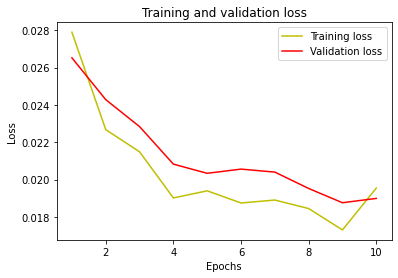

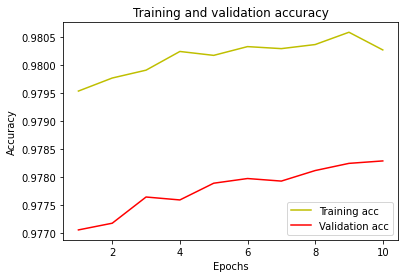

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


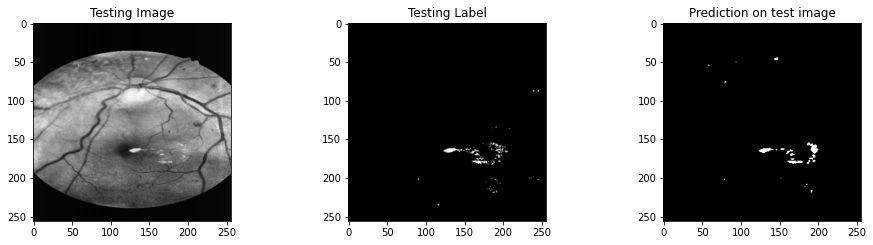

In [34]:
from keras.models import load_model
#model = load_model('unet_exe_seg.h5')
test_img_number = random.randint(0, len(image_test))
test_img = image_test[test_img_number]
ground_truth=mask_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')